## 1. Read Datasets

Read Mean Nighttime temperature for the month of July across Toronto using the MODIS LST_Night_1km band 

In [1]:
from lcz_classification.dataset import fetch_metadata
from lcz_classification.util import merge_rasters
from lcz_classification.config import *
import rioxarray as rio
from rasterstats import zonal_stats
import rasterio as r
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rasterio.enums import Resampling



- Parent directory for Cairo already exists, retrievine folder paths...
- Folder paths for Cairo retrieved.


In [2]:
if os.path.exists(LST_FP) == False:
    
    ch_files= [f"{LST_RAW}/{tif}" for tif in os.listdir(LST_RAW) if ".tif.aux.xml" not in tif] # prepare file paths of DSM tiles

    merge_rasters(
                raster_paths=ch_files,
                out_path=LST_FP,
                transform=None
                ) # merge into a single raster using merge_arrays()

lst_n=rio.open_rasterio(LST_FP)
lst_n = (lst_n * 0.02)- 273.15

lcz_legend=fetch_metadata('LCZ_LEGEND')
lcz_30m=rio.open_rasterio(CLASSIFIED_CLIPPED_FP)

lst_n=lst_n.rio.reproject_match(lcz_30m, resampling=Resampling.average)

In [3]:
area=fetch_metadata('STUDY_AREA')
area.geometry=area.force_2d()
# area.to_file('../data/toronto/study_area/shp/toronto_shp.shp')

## 2. Retrieve Temperature Values for each LCZ Class

In [4]:

temp_n=lst_n.sel(band = 1).values
lcz=lcz_30m.sel(band=1).values

mask= lcz == lcz_30m.attrs['_FillValue']


classes = np.unique(lcz[~mask])
labels=[lcz_legend.set_index('class').loc[cl]['name'] for cl in classes]
palette=[lcz_legend.set_index('class').loc[cl] for cl in classes]
palette=['#%02x%02x%02x' % (l.r,l.g,l.b) for l in palette]


def mask_vals(target_class,class_layer, var_layer):
    mask = class_layer==target_class
    vals=var_layer[mask]
    vals=vals[~np.isnan(vals)]
    return vals



def mask_stats(target_class,class_layer, var_layer):
    mask = class_layer==target_class
    vals=var_layer[mask]
    vals=vals[~np.isnan(vals)]

    return dict(
        class_val=target_class,
        mean=np.nanmean(vals,axis=0),
        min=np.nanmin(vals),
        max=np.nanmax(vals),
        median=np.nanmedian(vals),
        std=np.nanstd(vals),
        range=np.nanmax(vals) - np.nanmin(vals)
    )

stats_vals=[mask_vals(target_class,lcz,temp_n) for target_class in classes]
stats_dict=[mask_stats(target_class,lcz,temp_n) for target_class in classes]
stats_df=pd.DataFrame(stats_dict)
stats_df['name']=labels

stats_df.sort_values('mean', ascending=False).set_index('name').drop(columns='class_val').round(1).to_csv('../reports/temp_stats.csv')

## 3. Plot Thermal Trends of LCZ Classes

C:\Users\medo_\AppData\Local\Temp\ipykernel_32488\549852482.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_d, y= labels, palette=palette, legend=False)


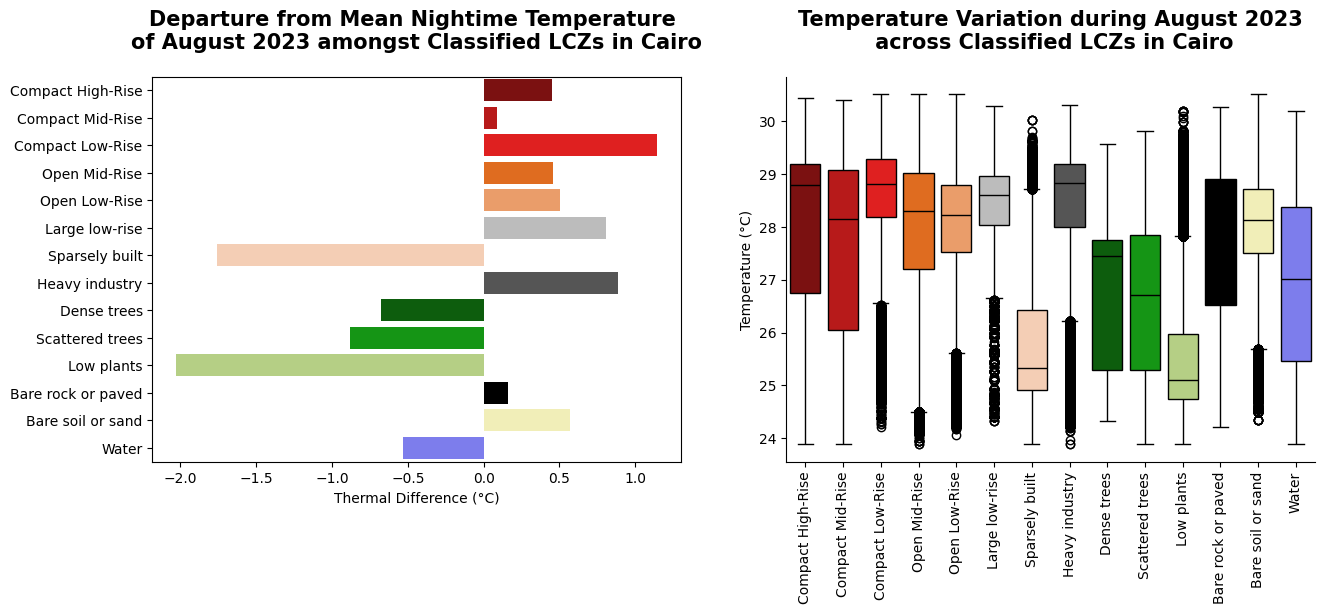

In [7]:


fig, ax = plt.subplots(1,2, figsize=(15,5))


# ## Thermal Departure from Mean Nightime Temperature
plt.sca(ax[0])
lcz_means=stats_df['mean']
mean_temp=np.nanmean(temp_n)

mean_d=lcz_means - mean_temp

sns.barplot(x=mean_d, y= labels, palette=palette, legend=False)
plt.xlabel('Thermal Difference (°C)')
ax[1].set_xlim([-2.0,2.0])
plt.title('Departure from Mean Nightime Temperature \nof August 2023 amongst Classified LCZs in Cairo', fontdict=dict(size= 15, weight='bold'), pad=20)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

## LCZ Class Box Plots
plt.sca(ax[1])
sns.boxplot(data=stats_vals, palette = palette,)
plt.xticks(ticks=list(range(0,len(classes))),labels=labels, rotation=90)
plt.ylabel('Temperature (°C)')
plt.title('Temperature Variation during August 2023\n across Classified LCZs in Cairo', fontdict=dict(size= 15, weight='bold'), pad=20)


plt.savefig('../reports/figures/temp_barplots.png', dpi=300, bbox_inches='tight', )


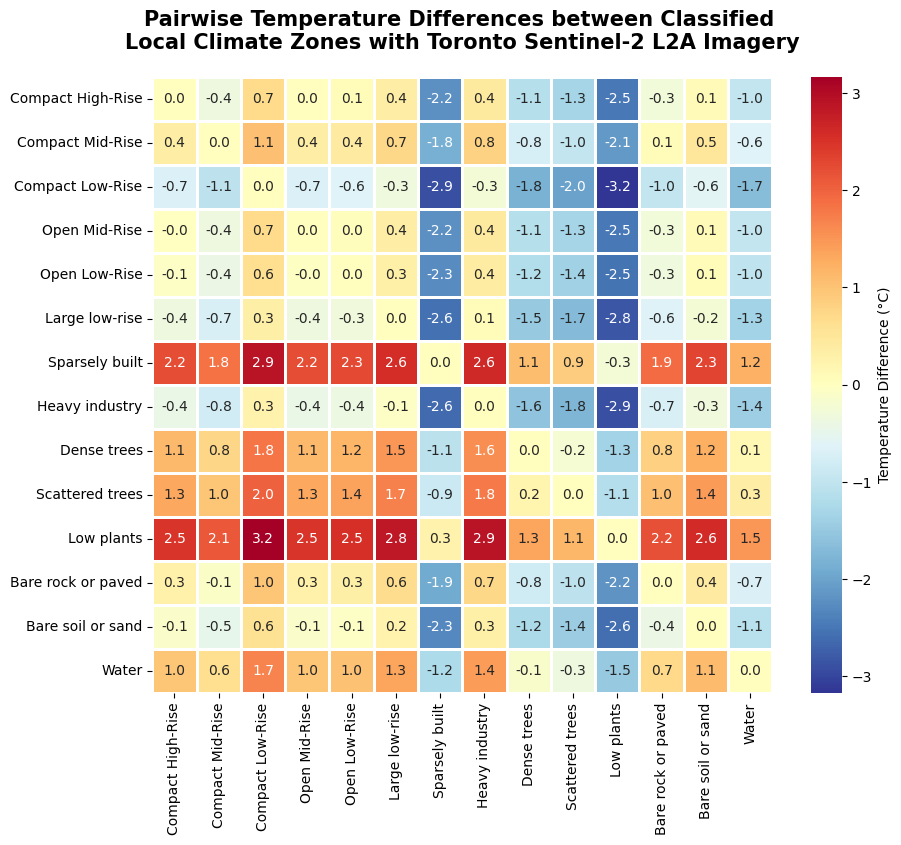

In [6]:
## Pairwise Temperature Differences from LCZ Classes
plt.figure(figsize=(10,8))
mean_vals=stats_df['mean']
mx,my=np.meshgrid(mean_vals,mean_vals)

pairwise_difference = (mx-my)

sns.heatmap(pairwise_difference, 
        annot=True, 
        fmt="0.1f", 
        cmap='RdYlBu_r',
        cbar=True,
        xticklabels=labels, 
        yticklabels=labels, 
        # mask=mask,
        linewidths=1,
        linecolor='white',
        cbar_kws=dict(label='Temperature Difference (°C)')
        )

plt.title('Pairwise Temperature Differences between Classified \nLocal Climate Zones with Toronto Sentinel-2 L2A Imagery',fontdict=dict(size= 15, weight='bold'), pad=20)

plt.savefig('../reports/figures/temp_pairwise.png', dpi=300, bbox_inches='tight' )